# Importar librerías necesarias
Esta celda importa las librerías esenciales para el análisis:
- `re`, `os`, `csv`, `math` para operaciones y utilidades básicas.
- `collections.Counter` y `defaultdict` para contar y agrupar.
- `pandas` para manipulación de tablas.
- `networkx` para construir y analizar grafos.
- `matplotlib.pyplot` para visualización del grafo.
Se colocan aquí para que el resto del notebook pueda usar estas dependencias sin repetir importaciones.

In [7]:
import re
import os
import csv
import math
from collections import defaultdict, Counter
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json


# Cargar términos desde los CSV de Requerimiento 3
Lee archivos CSV generados en Requerimiento 3 y extrae columnas de términos.
Normaliza cada término (minúsculas, reemplazo de guiones, colapso de espacios), elimina duplicados preservando el orden, y construye la lista `terms` que se usará como nodos en el grafo.

In [8]:


path_cat = "../../proyecto/requerimiento3/frecuencias_palabras_categoria.csv"
path_top15 = "../../proyecto/requerimiento3/top15_palabras_frecuentes.csv"

# Helper para leer columna de palabras (intenta varias columnas/formatos)
def read_terms_from_csv(path, possible_cols=None):
    df = pd.read_csv(path)
    if possible_cols is None:
        possible_cols = df.columns.tolist()
    # busca la primera columna que parezca contener texto de términos
    for col in possible_cols:
        if df[col].dtype == object:
            terms = df[col].dropna().astype(str).tolist()
            if len(terms) > 0:
                return terms
    # fallback: tomar todo como strings
    return df.astype(str).stack().unique().tolist()

terms_cat = read_terms_from_csv(path_cat)
terms_top15 = read_terms_from_csv(path_top15)

# Unir, normalizar y quitar duplicados (preservando frases)
def normalize_term(t):
    t = t.strip().lower()
    t = t.replace('-', ' ')  # fine-tuning -> fine tuning
    t = re.sub(r'\s+', ' ', t)
    return t

terms_set = [normalize_term(t) for t in (terms_cat + terms_top15)]
# eliminar duplicados preservando orden
seen = set()
terms = []
for t in terms_set:
    if t not in seen and t != "":
        seen.add(t)
        terms.append(t)

print(f"Loaded {len(terms_cat)} terms from category CSV, {len(terms_top15)} from top15.")
print(f"Total unique candidate terms (nodes): {len(terms)}")
print("Example terms:", terms[:20])


Loaded 15 terms from category CSV, 15 from top15.
Total unique candidate terms (nodes): 30
Example terms: ['machine learning', 'privacy', 'generative models', 'training data', 'transparency', 'ethics', 'explainability', 'personalization', 'prompting', 'algorithmic bias', 'multimodality', 'fine tuning', 'human ai interaction', 'ai literacy', 'co creation', 'data', 'learning', 'model', 'generative', 'models']


## Reconstruimos a partir de consolidado.bib (misma limpieza usada antes). en el requerimiento 3

Lee el archivo `.bib` consolidado, extrae los abstracts y aplica una limpieza básica: pasar a minúsculas, eliminar caracteres no alfanuméricos (conservando dígitos y guiones temporalmente), normalizar guiones y colapsar espacios.
El resultado se almacena en `abstracts_limpios` y es la base para detectar coocurrencias entre términos.

In [9]:


try:
    abstracts_limpios  # si existe en memoria se usa
    print("Using existing 'abstracts_limpios' from memoria.")
except NameError:
    # Si no existe, leemos el .bib y limpiamos
    import bibtexparser
    ruta_bib = "consolidado.bib"  # ajusta si está en otra carpeta
    with open(ruta_bib, encoding="utf-8") as bibtex_file:
        bib_database = bibtexparser.load(bibtex_file)
    raw_abstracts = [entry["abstract"] for entry in bib_database.entries if "abstract" in entry]
    print(f"Found {len(raw_abstracts)} raw abstracts in .bib")
    # misma función de limpieza que antes (puedes ajustarla)
    import nltk
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))
    def limpiar_texto_simple(texto):
        texto = (texto or "").lower()
        texto = re.sub(r'[^a-z0-9\s\-]', ' ', texto)  # permitimos numeros y guiones temporalmente
        texto = texto.replace('-', ' ')
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    abstracts_limpios = [limpiar_texto_simple(a) for a in raw_abstracts]
    # filtrar vacíos
    filtered = [(a,t) for a,t in zip(abstracts_limpios, [entry.get("title","") for entry in bib_database.entries if "abstract" in entry]) if a.strip() != ""]
    abstracts_limpios = [a for a,t in filtered]
    print(f"{len(abstracts_limpios)} abstracts remain after cleaning/filtering.")


Found 9443 raw abstracts in .bib
9402 abstracts remain after cleaning/filtering.


## CELDA 4: construcción automática del grafo de coocurrencia
### Reglas:
    - Nodo por término en `terms` (frases o palabras).
    - Dos términos conectados si aparecen juntos en al menos un documento.
    - Arista con peso = número de documentos donde coocurren.

Compila expresiones regulares para cada término y recorre cada abstract para detectar qué términos aparecen en él.
Para cada documento se registra el conjunto único de términos encontrados, se cuentan todas las combinaciones de pares (coocurrencias) y se acumulan pesos (número de documentos donde coocurren).
Finalmente se crea el grafo no dirigido `G` con el atributo `weight` en cada arista.

In [10]:

# Precompilación de patrones para buscar términos (coinciende palabras completas)
term_patterns = []
for t in terms:
    # escapamos y usamos r'\b' para bordes de palabra, pero si t contiene espacios (frase) lo usamos tal cual
    pat = r'\b' + re.escape(t) + r'\b'
    term_patterns.append((t, re.compile(pat, flags=re.IGNORECASE)))

# Data structures
G = nx.Graph()
G.add_nodes_from(terms)  # nodos etiquetados por el término normalizado

# contador de coocurrencias (edge weights)
edge_weights = Counter()

# contador de presencia por término (para ver en cuántos documentos aparece cada término)
term_doc_count = Counter()

# Para cada documento, detectamos qué términos aparecen (lista única por doc)
for doc_idx, doc in enumerate(abstracts_limpios):
    found = []
    for term, pattern in term_patterns:
        if pattern.search(doc):
            found.append(term)
            term_doc_count[term] += 1
    # todas las combinaciones de pares (undirected)
    for i in range(len(found)):
        for j in range(i+1, len(found)):
            a = found[i]
            b = found[j]
            if a == b: 
                continue
            # orden canonical para la llave
            key = tuple(sorted((a,b)))
            edge_weights[key] += 1

# Agregar aristas al grafo con atributo 'weight'
for (a,b), w in edge_weights.items():
    G.add_edge(a, b, weight=w)

# Quitar nodos aislados si deseas (opcional). Aquí mantengo todos, pero puedes filtrar:
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")


Graph built: 30 nodes, 387 edges.


# Cálculo de grado y detección de componentes
Calcula:
- Grado simple (`degree`) para cada nodo,
- Grado ponderado por la suma de pesos de sus aristas,
- Componentes conexas del grafo no dirigido usando `networkx.connected_components`.
Además crea dataframes resumen, guarda CSVs y GraphML, y genera un listado detallado de las componentes (miembros y tamaño).

In [11]:
# CELDA 5: grado de cada nodo y componentes conexas

# grado (número de vecinos). Para grafo no ponderado:
degree_dict = dict(G.degree())  # grado simple
# también grado ponderado por peso:
weighted_degree = {n: sum(d.get('weight',1) for _,_,d in G.edges(n, data=True)) for n in G.nodes()}

# crear dataframe resumen
df_nodes = pd.DataFrame({
    "term": list(G.nodes()),
    "degree": [degree_dict[t] for t in G.nodes()],
    "weighted_degree": [weighted_degree[t] for t in G.nodes()],
    "doc_frequency": [term_doc_count.get(t, 0) for t in G.nodes()]  # en cuántos abstracts aparece
}).sort_values(by=["degree","weighted_degree"], ascending=False)

# componentes conexas
components = list(nx.connected_components(G))
comp_list = []
for comp_id, comp in enumerate(components, start=1):
    for term in comp:
        comp_list.append({"term": term, "component_id": comp_id, "component_size": len(comp)})

df_components = pd.DataFrame(comp_list)

# merge resumen
df_summary = df_nodes.merge(df_components, on="term", how="left").sort_values(by=["component_size","degree"], ascending=[False,False])

# --- Mostrar y guardar componentes conexas (undirected) detalladas ---
print("\nComponentes conexas (undirected) - detalles:")
# construir lista con miembros como string
components_info = []
for comp_id, comp in enumerate(components, start=1):
    members = sorted(list(comp))
    # guardamos la lista de miembros como JSON para evitar romper el CSV al contener comas/espacios/otras separaciones
    components_info.append({'component_id': comp_id, 'component_size': len(comp), 'members': json.dumps(members, ensure_ascii=False)})

# DataFrame y guardado
df_components_full = pd.DataFrame(components_info).sort_values(by='component_size', ascending=False)

# Añadir una vista previa legible de los miembros (primeros 10) para impresión
def _members_preview(members_str, n=10):
    if not isinstance(members_str, str) or members_str.strip() == '':
        return ''
    # members_str ahora es un JSON serializado: parsearlo
    try:
        members = json.loads(members_str)
    except Exception:
        # fallback si no es JSON; intentar dividir por punto y coma o tabulador
        if ';' in members_str:
            members = members_str.split(';')
        elif '\t' in members_str:
            members = members_str.split('\t')
        else:
            members = members_str.split()
    if len(members) <= n:
        return ', '.join(members)
    return ', '.join(members[:n]) + f' ... (+{len(members)-n} más)'

df_components_full['members_preview'] = df_components_full['members'].apply(lambda s: _members_preview(s, n=10))

# Columnas para mostrar: id, tamaño y preview de miembros
display_cols = ['component_id','component_size','members_preview']
# Mostrar tabla (HTML si está disponible) para que se vea bien en el notebook
try:
    from IPython.display import display, HTML
    display(HTML(df_components_full[display_cols].head(50).to_html(index=False)))
except Exception:
    print(df_components_full[display_cols].head(50).to_string(index=False))

# filtrado de componentes con más de 1 término
components_large = df_components_full[df_components_full['component_size'] > 1].copy()
print("\nNúmero de componentes con más de 1 término (detallado): ", len(components_large))

# Mostrar la tabla de componentes grandes (si las hay) con preview
if not components_large.empty:
    try:
        display(HTML(components_large[display_cols].head(200).to_html(index=False)))
    except Exception:
        print(components_large[display_cols].head(200).to_string(index=False))

# Guardar CSVs de salida
out_dir = "datas"
os.makedirs(out_dir, exist_ok=True)

# Renombrar columnas al español para el CSV de resumen de nodos
df_summary_es = df_summary.rename(columns={
    'term':'termino',
    'degree':'grado',
    'weighted_degree':'grado_ponderado',
    'doc_frequency':'frecuencia_documentos',
    'component_id':'componente_id',
    'component_size':'tamano_componente'
})

resumen_path = os.path.join(out_dir, "resumen_nodos_coocurrencia.csv")
df_summary_es.to_csv(resumen_path, index=False, encoding='utf-8')

# También guardar la lista de aristas con peso (columnas en español)
edges_out = pd.DataFrame([{'term_a':a, 'term_b':b, 'weight':w} for (a,b),w in edge_weights.items()])
edges_out_es = edges_out.rename(columns={'term_a':'termino_a','term_b':'termino_b','weight':'peso'})
edges_path = os.path.join(out_dir, "lista_aristas_coocurrencia.csv")
edges_out_es.to_csv(edges_path, index=False, encoding='utf-8')

# Guardar CSV con componentes detalladas
components_path = os.path.join(out_dir, "componentes_conexas_coocurrencia.csv")
# Usar quoting para que el campo 'members' (JSON) quede correctamente entrecomillado y no rompa el CSV
import csv as _csv_mod
df_components_full.to_csv(components_path, index=False, encoding='utf-8', quoting=_csv_mod.QUOTE_ALL)

# Guardar el grafo completo en formato GraphML para que pueda reutilizarse en Gephi u otras herramientas
graphml_path = os.path.join(out_dir, "grafo_coocurrencia.graphml")
nx.write_graphml(G, graphml_path)

print("Resumen de nodos guardado en:", resumen_path)
print("Lista de aristas guardada en:", edges_path)
print("Grafo completo guardado en:", graphml_path)
print(f"Se encontraron {len(components)} componentes conexas (incluidos posibles nodos aislados).")
print("Componentes (detalladas) guardadas en:", components_path)



Componentes conexas (undirected) - detalles:


component_id,component_size,members_preview
1,30,"adversarial, ai literacy, algorithmic bias, co creation, data, ethics, explainability, fine tuning, generative, generative models ... (+20 más)"



Número de componentes con más de 1 término (detallado):  1


component_id,component_size,members_preview
1,30,"adversarial, ai literacy, algorithmic bias, co creation, data, ethics, explainability, fine tuning, generative, generative models ... (+20 más)"


Resumen de nodos guardado en: datas\resumen_nodos_coocurrencia.csv
Lista de aristas guardada en: datas\lista_aristas_coocurrencia.csv
Grafo completo guardado en: datas\grafo_coocurrencia.graphml
Se encontraron 1 componentes conexas (incluidos posibles nodos aislados).
Componentes (detalladas) guardadas en: datas\componentes_conexas_coocurrencia.csv


In [12]:
# Mostrar y guardar la tabla de grados de cada nodo (columnas en español)
# Creamos primero el DataFrame en español para evitar confusiones y luego lo mostramos/guardamos.
# Selección de columnas desde df_summary (si df_summary existe en memoria con nombres en inglés)
cols_needed = ['term','degree','weighted_degree','doc_frequency']
for c in cols_needed:
    if c not in df_summary.columns:
        raise KeyError(f'Column {c} no encontrada en df_summary. Ejecuta la celda previa que crea df_summary.')

# Crear copia y renombrar columnas al español
df_degs_es = df_summary[cols_needed].copy()
df_degs_es.columns = ['termino','grado','grado_ponderado','frecuencia_documentos']

# Mostrar los  términos por grado (más conectados) con cabeceras en español
print('Términos por grado (más conectados):')
display(df_degs_es.sort_values(by=['grado','grado_ponderado'], ascending=False).head(50))

# Asegurar que el directorio de salida exista y guardar CSV
os.makedirs(out_dir, exist_ok=True)
deg_path = os.path.join(out_dir, 'grados_nodos_coocurrencia.csv')
df_degs_es.to_csv(deg_path, index=False, encoding='utf-8')
print('CSV de grados guardado en:', deg_path)

# Preparar etiquetas con grado para la visualización (término + grado en segunda línea).
# Usamos degree_dict si está disponible; en caso contrario, caemos en df_degs_es.
if 'degree' in globals():
    pass  # placeholder if someone used a variable named 'degree' elsewhere
labels_with_degree = {}
for n in G.nodes():
    g = degree_dict.get(n) if 'degree_dict' in globals() else None
    if g is None:
        # buscar en df_degs_es
        try:
            g = int(df_degs_es.loc[df_degs_es['termino'] == n, 'grado'].iloc[0])
        except Exception:
            g = 0
    labels_with_degree[n] = f"{n}\n({g})"

# Nota: la celda de visualización usará estas etiquetas para el subgrafo 'subG'

Términos por grado (más conectados):


,termino,grado,grado_ponderado,frecuencia_documentos
0,generative,29,31091,5398
1,learning,29,27113,4603
2,data,29,26713,4472
3,model,29,26055,4306
4,paper,29,21283,3786
5,using,29,19107,3186
6,intelligence,29,17203,3513
7,image,29,16860,2620
8,privacy,29,3520,576
9,models,28,21433,3609


CSV de grados guardado en: datas\grados_nodos_coocurrencia.csv


# Visualización del grafo y subgrafo top-N
Prepara y dibuja un subgrafo con los `topN` términos por grado:
- Calcula posiciones con `spring_layout`,
- Ajusta tamaño de nodo según grado y grosor de arista según peso,
- Dibuja nodos, aristas y etiquetas con estilo para facilitar la lectura.

📊 Resumen - Top términos por grado:


,term,degree,weighted_degree,doc_frequency,component_id,component_size
0,generative,29,31091,5398,1,30
1,learning,29,27113,4603,1,30
2,data,29,26713,4472,1,30
3,model,29,26055,4306,1,30
4,paper,29,21283,3786,1,30
5,using,29,19107,3186,1,30
6,intelligence,29,17203,3513,1,30
7,image,29,16860,2620,1,30
8,privacy,29,3520,576,1,30
9,models,28,21433,3609,1,30


C:\Users\camil\AppData\Local\Temp\ipykernel_17152\2668353124.py:190: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\camil\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


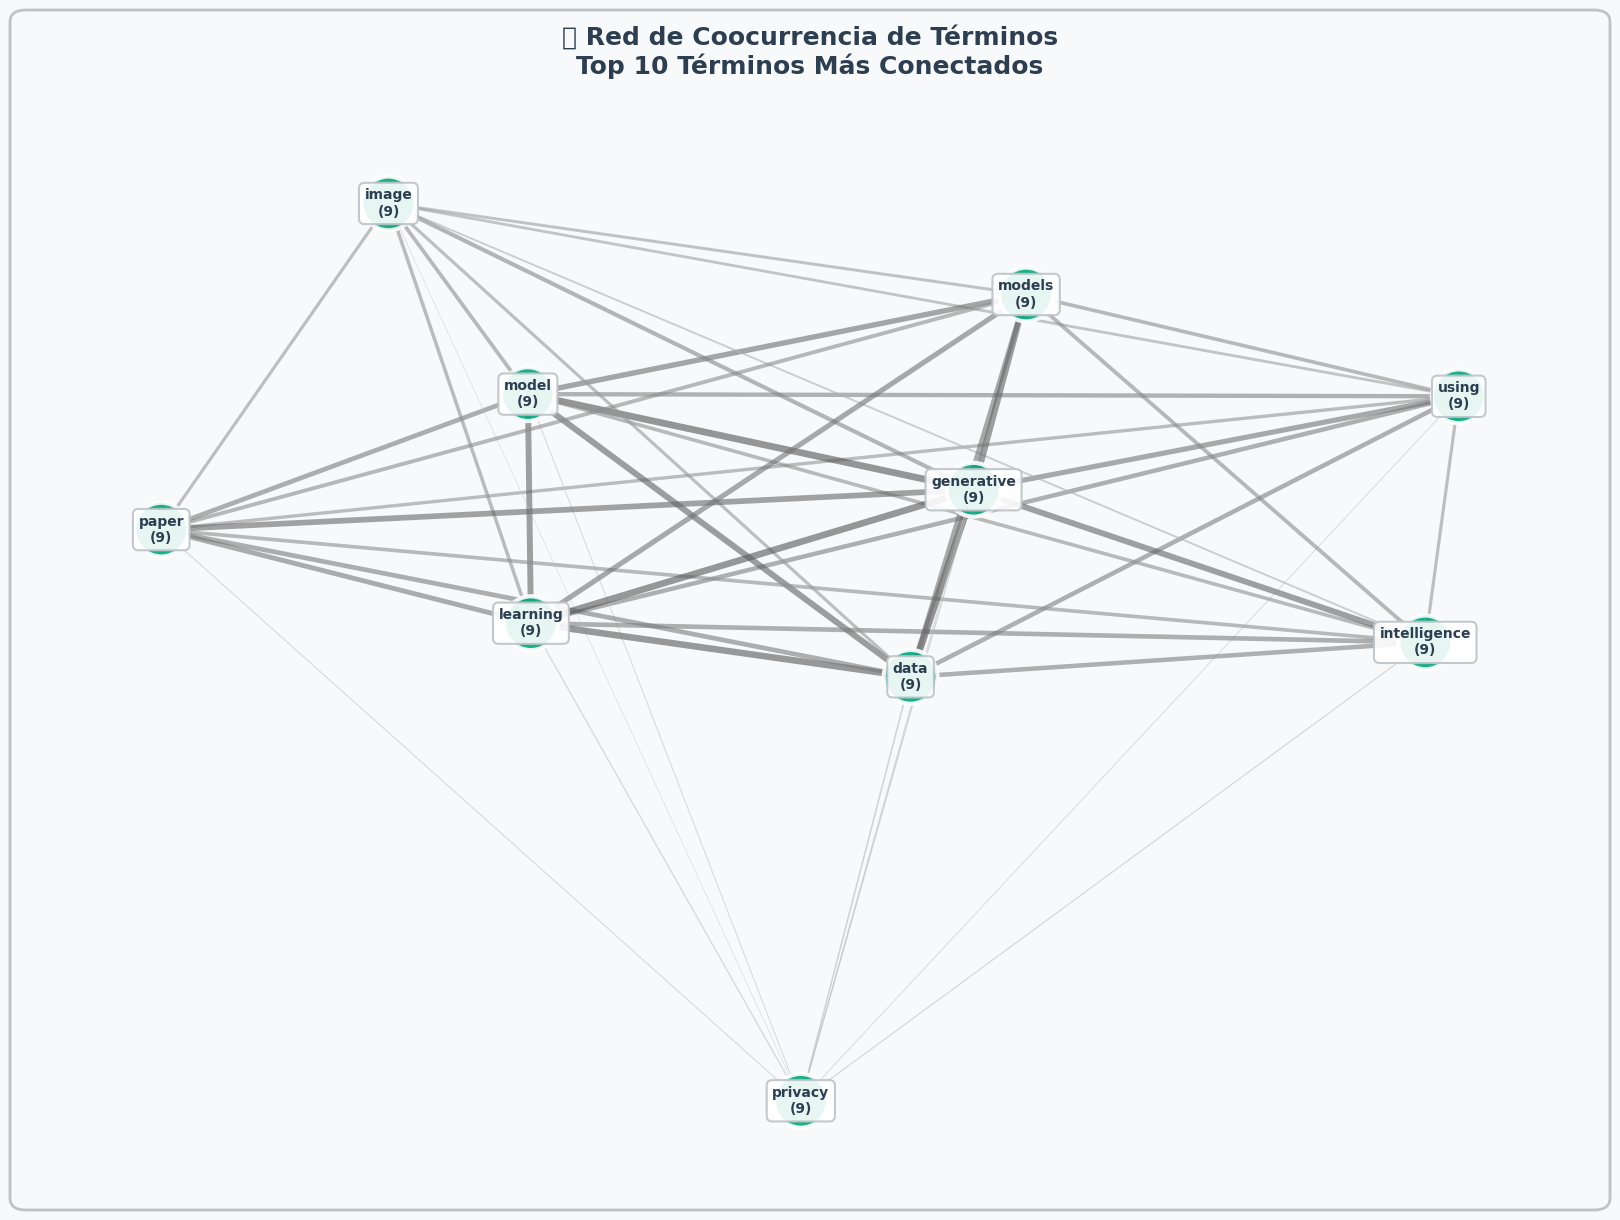


📈 ANÁLISIS COMPLETADO

✓ Se visualizaron los 10 términos más conectados
✓ Rango de conectividad: 9 - 9
✓ Total de relaciones mostradas: 45

💡 Interpretación de colores:
   • Azul → Verde → Amarillo → Rojo: Aumenta la conectividad
   • Tamaño del nodo: Proporcional al grado de conexión
   • Grosor de línea: Proporcional a la fuerza de la relación


In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import numpy as np
import math

# ============================================
# CONFIGURACIÓN Y PREPARACIÓN DE DATOS
# ============================================

# Mostrar resumen de los términos más conectados
print('📊 Resumen - Top términos por grado:')
display(df_summary.head(20))

# Subgrafo con los top N términos más conectados
topN = 10  # Ajusta este valor según necesites: 10, 20, 30...
top_terms = df_summary.head(topN)["term"].tolist()
subG = G.subgraph(top_terms).copy()

# ============================================
# CÁLCULO DE MÉTRICAS Y POSICIONES
# ============================================

# Calcular posiciones con mejor distribución
pos = nx.spring_layout(subG, seed=42, k=1.2, iterations=150)

# Calcular métricas para cada nodo
degrees = dict(subG.degree())
max_degree = max(degrees.values())
min_degree = min(degrees.values())

# Normalizar grados para tamaños de nodos (rango 300-3000)
if max_degree == min_degree:
    # Todos los nodos tienen el mismo grado
    node_sizes = [1500 for n in subG.nodes()]  # Tamaño medio
else:
    node_sizes = [300 + 2700 * (degrees[n] - min_degree) / (max_degree - min_degree) 
                  for n in subG.nodes()]

# Calcular pesos de aristas
edge_weights = [d["weight"] for _, _, d in subG.edges(data=True)]
max_weight = max(edge_weights) if edge_weights else 1
min_weight = min(edge_weights) if edge_weights else 0

# Normalizar anchos de aristas (rango 0.5-5)
if max_weight == min_weight or not edge_weights:
    # Todas las aristas tienen el mismo peso
    edge_widths = [2.5 for _ in subG.edges()]  # Ancho medio
else:
    edge_widths = [0.5 + 4.5 * (d["weight"] - min_weight) / (max_weight - min_weight) 
                   for _, _, d in subG.edges(data=True)]

# Generar colores degradados para nodos según grado
def get_node_colors(degrees_dict):
    """Genera colores en degradado del azul al rojo según el grado"""
    norm_degrees = np.array([degrees_dict[n] for n in subG.nodes()])
    
    # Evitar división por cero
    if norm_degrees.max() == norm_degrees.min():
        # Todos tienen el mismo grado, usar color medio
        return ['#06A77D'] * len(subG.nodes())
    
    norm_degrees = (norm_degrees - norm_degrees.min()) / (norm_degrees.max() - norm_degrees.min())
    
    # Degradado: azul (#2E86AB) -> verde (#06A77D) -> amarillo (#F5BE47) -> rojo (#D62246)
    colors = []
    for val in norm_degrees:
        if val < 0.33:
            # Azul a Verde
            t = val / 0.33
            r = int(0x2E + (0x06 - 0x2E) * t)
            g = int(0x86 + (0xA7 - 0x86) * t)
            b = int(0xAB + (0x7D - 0xAB) * t)
        elif val < 0.66:
            # Verde a Amarillo
            t = (val - 0.33) / 0.33
            r = int(0x06 + (0xF5 - 0x06) * t)
            g = int(0xA7 + (0xBE - 0xA7) * t)
            b = int(0x7D + (0x47 - 0x7D) * t)
        else:
            # Amarillo a Rojo
            t = (val - 0.66) / 0.34
            r = int(0xF5 + (0xD6 - 0xF5) * t)
            g = int(0xBE + (0x22 - 0xBE) * t)
            b = int(0x47 + (0x46 - 0x47) * t)
        
        colors.append(f'#{r:02x}{g:02x}{b:02x}')
    
    return colors

node_colors = get_node_colors(degrees)

# Generar colores para aristas según peso
def get_edge_colors(weights):
    """Genera colores para aristas según su peso"""
    if not weights:
        return []
    
    norm_weights = np.array(weights)
    
    # Evitar división por cero
    if norm_weights.max() == norm_weights.min():
        # Todos los pesos son iguales, usar color medio
        return ['#808080'] * len(weights)
    
    norm_weights = (norm_weights - norm_weights.min()) / (norm_weights.max() - norm_weights.min())
    
    colors = []
    for val in norm_weights:
        # De gris claro a gris oscuro
        intensity = int(200 - 120 * val)
        colors.append(f'#{intensity:02x}{intensity:02x}{intensity:02x}')
    
    return colors

edge_colors = get_edge_colors(edge_weights)

# ============================================
# CREAR VISUALIZACIÓN
# ============================================

# Configurar figura con fondo elegante
fig, ax = plt.subplots(figsize=(16, 12), facecolor='#F8F9FA')
ax.set_facecolor('#FFFFFF')

# Título principal con estilo
title_text = f"🔗 Red de Coocurrencia de Términos\nTop {topN} Términos Más Conectados"
plt.title(title_text, 
          fontsize=18, 
          weight='bold', 
          pad=25,
          color='#2C3E50',
          family='sans-serif')

# Dibujar aristas con degradado de color
nx.draw_networkx_edges(
    subG, pos,
    width=edge_widths,
    edge_color=edge_colors,
    alpha=0.6,
    style='solid',
    ax=ax
)

# Dibujar nodos con colores degradados
nx.draw_networkx_nodes(
    subG, pos,
    node_size=node_sizes,
    node_color=node_colors,
    alpha=0.9,
    edgecolors='white',
    linewidths=3,
    ax=ax
)

# Preparar etiquetas mejoradas
labels_enhanced = {}
for n in subG.nodes():
    degree = degrees[n]
    # Truncar términos muy largos
    term_display = n if len(n) <= 12 else n[:10] + '...'
    labels_enhanced[n] = f"{term_display}\n({degree})"

# Dibujar etiquetas con mejor formato
nx.draw_networkx_labels(
    subG, pos,
    labels=labels_enhanced,
    font_size=10,
    font_weight='bold',
    font_color='#2C3E50',
    font_family='sans-serif',
    bbox=dict(
        facecolor='white',
        edgecolor='#BDC3C7',
        alpha=0.9,
        boxstyle='round,pad=0.4',
        linewidth=1.5
    ),
    ax=ax
)



# ============================================
# FINALIZAR Y MOSTRAR
# ============================================

plt.axis('off')
plt.tight_layout()

# Agregar borde decorativo
rect = FancyBboxPatch(
    (0.01, 0.01), 0.98, 0.98,
    transform=fig.transFigure,
    boxstyle="round,pad=0.01",
    edgecolor='#BDC3C7',
    facecolor='none',
    linewidth=2,
    linestyle='-'
)
fig.patches.append(rect)

plt.show()

# ============================================
# INFORMACIÓN ADICIONAL EN CONSOLA
# ============================================

print("\n" + "="*60)
print("📈 ANÁLISIS COMPLETADO")
print("="*60)
print(f"\n✓ Se visualizaron los {topN} términos más conectados")
print(f"✓ Rango de conectividad: {min_degree} - {max_degree}")
print(f"✓ Total de relaciones mostradas: {subG.number_of_edges()}")
print("\n💡 Interpretación de colores:")
print("   • Azul → Verde → Amarillo → Rojo: Aumenta la conectividad")
print("   • Tamaño del nodo: Proporcional al grado de conexión")
print("   • Grosor de línea: Proporcional a la fuerza de la relación")
print("="*60)
